In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/PASCAL/VOCdevkit/VOC2007/'
%ls

/content/gdrive/MyDrive/PASCAL/VOCdevkit/VOC2007
Annotations/  Finetune/   JPEGImages/  samples.pickle  SegmentationClass/
df.csv        ImageSets/  loss.png     seg_df.csv      SegmentationObject/


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

import cv2

import pickle

전처리한 df [Object Detection.ipynb](https://github.com/hodurie/AI_Study/blob/master/Implementation/Datasets/Object%20Detection.ipynb)

In [5]:
df = pd.read_csv('df.csv')
df.head()

,file_name,file_type,object_length,object,xmin,ymin,xmax,ymax,pose,truncated,difficult
0,000012.jpg,train,1,car,156,97,351,270,Rear,0,0
1,000017.jpg,train,2,person,185,62,279,199,Left,0,0
2,000017.jpg,train,2,horse,90,78,403,336,Left,0,0
3,000023.jpg,train,6,bicycle,9,230,245,500,Unspecified,1,0
4,000023.jpg,train,6,bicycle,230,220,334,500,Frontal,1,0


PASCAL VOC 2007 directory
```
/VOCdevkit//VOC2007/
├── df.csv                        # Object Detection 전처리 csv
├── samples.pickle                # 선정 된 file 이름 pickle
└── Finetune                      # positive_list, negative_list txt 폴더
     ├── models                   # 학습 모델 pth 
     ├── train                    # Segmentation 전처리 csv
     │   ├── bbox                # bbox csv 파일
     │   ├── *_n.csv / *_p.csv   # negative / positive csv (iou 0.5 기준 나눔)
     │   ├── Annotations         # negative / positive csv (iou 0.3 기준 나눔)
     │   ├── positive            # score 0.6 이상 bndboxes
     │   │   └── *_n.csv / *_p.csv
     │   └── bndboxes            # 기존 bndboxes
     │        └── *_n.csv / *_p.csv
     └── validation
          └── Annotations


# 기존 PASCAL VOC 2007 directory 구조
/VOCdevkit//VOC2007/
├── Annotations           
│   └── *.xml        
├── ImageSets
│   ├── Layout
│   │   └── *.txt
│   ├── Main
│   │   └── *.txt
│   └── Segmentation
│        └── *.txt
├── JPEGImages
│   └── .jpg
├── SegmentationClass
│   └── *.png
└── SegmentationObject
     └── *.png

```


In [8]:
finetune_root_dir = './Finetune/'

if not os.path.exists(finetune_root_dir):
    os.mkdir(finetune_root_dir)

for name in ['train', 'validation']:
    dst_root_dir = os.path.join(finetune_root_dir, name)

    if not os.path.exists(dst_root_dir):
        os.mkdir(dst_root_dir)

    dst_annotation_dir = os.path.join(finetune_root_dir, name, 'Annotations')
    if not os.path.exists(dst_annotation_dir):
        os.mkdir(dst_annotation_dir)

특정 obj 만 추출해서 sample 만들기

In [9]:
def sample_split(df, obj='car'):
    # car dataset 사용
    cond = df['object'] == obj
    df = df[cond]

    samples = {}

    for name in ['train', 'validation']:
        cond = df['file_type'] == name
        sample = df.loc[cond, 'file_name'].unique()

        length = len(sample)
        
        indices = random.sample(range(length), int(length / 2))
        
        samples[name] = sample[indices]

    return samples

In [10]:
def IoU(pred_box, target_box):
    '''
    pred_box = [4] 
    target_box = [N, 4]
    '''
    # (xmax - xmin) * (ymax - ymin)

    if len(target_box.shape) == 1:
        target_box = target_box[np.newaxis, :]

    areaA = (target_box[:, 2] - target_box[:, 0]) * (target_box[:, 3] - target_box[:, 1])
    areaB = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])

    xA = np.maximum(pred_box[0], target_box[:, 0])
    yA = np.maximum(pred_box[1], target_box[:, 1])
    xB = np.minimum(pred_box[2], target_box[:, 2])
    yB = np.minimum(pred_box[3], target_box[:, 3])
    
    intersection = np.maximum(0.0, xB - xA) * np.maximum(0.0, yB - yA)
    
    scores = intersection / (areaA + areaB - intersection)

    return scores

In [11]:
def region_proposals(jpg, gs):
    global df
    path = os.path.join('./JPEGImages/', jpg)
    img = cv2.imread(path)

    gs.setBaseImage(img)
    gs.switchToSelectiveSearchQuality()

    rects = gs.process()
    # rects[N, 4]
    # [[xmin, ymin, xmax, ymax],
    # [xmin, ymin, xmax, ymax], ... ]

    cond = df['file_name'] == jpg
    cols = ['xmin', 'ymin', 'xmax', 'ymax']
    bndboxes = np.array(df.loc[cond, cols])

    maximum_bndbox_size = 0

    for bndbox in bndboxes:
        xmin, ymin, xmax, ymax = bndbox
        bndbox_size = (xmax - xmin) * (ymax - ymin)
        if bndbox_size > maximum_bndbox_size:
            maximum_bndbox_size = bndbox_size

    iou_list = []
    for rect in rects:
        scores = IoU(rect, bndboxes)
        iou_list.append(max(scores))
    
    return iou_list, rects, maximum_bndbox_size, bndboxes

In [12]:
def parse_annotation_jpg(jpg, gs):
    iou_list, rects, maximum_bndbox_size, bndboxes = region_proposals(jpg, gs)

    positive_list = []
    negative_list = []

    for i in range(len(iou_list)):
        xmin, ymin, xmax, ymax = rects[i]
        rect_size = (xmax - xmin) * (ymax - ymin)

        iou_score = iou_list[i]

        if iou_score >= 0.5:
            positive_list.append(rects[i])
        
        if 0 < iou_score < 0.5 and rect_size > (maximum_bndbox_size / 5.0):
            negative_list.append(rects[i])
    
    return positive_list, negative_list

In [ ]:
gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

samples = sample_split(df)

for name in ['train', 'validation']:
    total_num_positive = 0
    total_num_negative = 0
    
    for sample in samples[name]:
        positive_list, negative_list = parse_annotation_jpg(sample, gs)
        total_num_positive += len(positive_list)
        total_num_negative += len(negative_list)

        finetune_path = os.path.join(finetune_root_dir, name)

        positive_list_path = os.path.join(finetune_path, sample.replace('.jpg', '_p.csv'))
        negative_list_path = os.path.join(finetune_path, sample.replace('.jpg', '_n.csv'))
        
        np.savetxt(positive_list_path, np.array(positive_list), fmt='%d', delimiter=' ')
        np.savetxt(negative_list_path, np.array(negative_list), fmt='%d', delimiter=' ')

    print('%s positive num: %d' % (name, total_num_positive))
    print('%s negative num: %d' % (name, total_num_negative))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


train positive num: 9658
train negative num: 67121
validation positive num: 7425
validation negative num: 54730


In [ ]:
with open('samples.pickle','wb') as fw:
    pickle.dump(samples, fw)

In [13]:
with open('samples.pickle', 'rb') as fr:
    samples = pickle.load(fr)

In [10]:
samples

{'train': array(['006748.jpg', '008784.jpg', '003083.jpg', '001937.jpg',
        '003806.jpg', '006822.jpg', '002559.jpg', '000153.jpg',
        '003971.jpg', '003484.jpg', '003551.jpg', '004687.jpg',
        '005090.jpg', '002490.jpg', '008388.jpg', '002134.jpg',
        '008037.jpg', '002116.jpg', '005499.jpg', '008197.jpg',
        '000431.jpg', '001780.jpg', '009283.jpg', '008232.jpg',
        '007479.jpg', '003261.jpg', '001414.jpg', '006734.jpg',
        '000888.jpg', '003355.jpg', '008391.jpg', '008549.jpg',
        '001494.jpg', '004481.jpg', '006079.jpg', '008174.jpg',
        '003420.jpg', '005047.jpg', '009392.jpg', '009424.jpg',
        '000522.jpg', '001112.jpg', '006224.jpg', '000590.jpg',
        '007898.jpg', '004091.jpg', '000134.jpg', '002625.jpg',
        '003231.jpg', '008909.jpg', '005831.jpg', '003103.jpg',
        '000026.jpg', '008466.jpg', '007305.jpg', '001881.jpg',
        '004705.jpg', '006931.jpg', '002478.jpg', '001119.jpg',
        '009810.jpg', '000754.j

In [14]:
def parse_annotation_jpeg_svm(jpg, gs):
    iou_list, rects, maximum_bndbox_size, bndboxs = region_proposals(jpg, gs)

    positive_list = []
    negative_list = []

    for i in range(len(iou_list)):
        xmin, ymin, xmax, ymax = rects[i]
        rect_size = (ymax - ymin) * (xmax - xmin)

        iou_score = iou_list[i]

        if 0 < iou_score <= 0.3 and rect_size > maximum_bndbox_size / 5.0:
            negative_list.append(rects[i])
        
    return bndboxs, negative_list

In [ ]:
gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

for name in ['train', 'validation']:
    total_num_positive = 0
    total_num_negative = 0

    for sample in samples[name]:
        positive_list, negative_list = parse_annotation_jpeg_svm(sample, gs)
        total_num_positive += len(positive_list)
        total_num_negative += len(negative_list)

        path = os.path.join(finetune_root_dir, name, 'Annotations')
        dst_annotation_positive_path = os.path.join(path, sample.replace('.jpg', '_p.csv'))
        dst_annotation_negative_path = os.path.join(path, sample.replace('.jpg', '_n.csv'))

        np.savetxt(dst_annotation_positive_path, np.array(positive_list), fmt='%d', delimiter=' ')
        np.savetxt(dst_annotation_negative_path, np.array(negative_list), fmt='%d', delimiter=' ')
    
    print('%s positive num: %d' % (name, total_num_positive))
    print('%s negative num: %d' % (name, total_num_negative))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


train positive num: 764
train negative num: 51056
validation positive num: 707
validation negative num: 41545


In [ ]:
res_samples = []
total_positive_num = 0

name = 'train'

bbox_csv_path = os.path.join(finetune_root_dir, name, 'bbox')
bndboxes_path = os.path.join(finetune_root_dir, name, 'bndboxes')
positive_path = os.path.join(finetune_root_dir, name, 'positive')

if not os.path.exists(bndboxes_path):
    os.mkdir(bndboxes_path)

if not os.path.exists(positive_path):
    os.mkdir(positive_path)

if not os.path.exists(bbox_csv_path):
    os.mkdir(bbox_csv_path)

for sample in samples[name]:
    # ex) 'Finetune/train/00001_p.csv
    path = os.path.join(finetune_root_dir, name, sample.replace('.jpg', '_p.csv'))
    # positive_bndboxes = [N, 4]
    positive_bndboxes = np.loadtxt(path, dtype=np.int, delimiter=' ')

    cols = ['xmin', 'ymin', 'xmax', 'ymax']
    train_df = df[df['file_name'] == sample]
    train_car = train_df.loc[df['object'] == 'car']

    # bndboxes = [N, 4]
    bndboxes = np.array(train_car[cols])
    
    positive_list = []

    # positive_bndboxes가 값을 하나 갖고 있을 때 (4)
    if len(positive_bndboxes.shape) == 1 and len(positive_bndboxes) != 0:
        scores = IoU(positive_bndboxes, bndboxes)
        if np.max(scores) > 0.6:
            positive_list.append(positive_bndboxes)
    # positive_bndboxes가 값을 여러 개 갖고 있을 때 (N, 4)
    elif len(positive_bndboxes.shape) == 2:
        for positive_bndbox in positive_bndboxes:
            scores = IoU(positive_bndbox, bndboxes)
            if np.max(scores) > 0.6:
                positive_list.append(positive_bndbox)

    if len(positive_list) > 0:
        # ex) 'Finetune/train/bndboxes/00001.csv
        bndboxes_paths = os.path.join(bndboxes_path, sample.replace('jpg', 'csv'))
        np.savetxt(bndboxes_paths, bndboxes, fmt='%s', delimiter=' ')

        # ex) 'Finetune/train/positive/00001.csv
        positive_paths = os.path.join(positive_path, sample.replace('jpg', 'csv'))
        np.savetxt(positive_paths, np.array(positive_list), fmt='%s', delimiter=' ')

        total_positive_num += len(positive_list)
        res_samples.append(sample)
        print('save {} done'.format(sample))
    else:
        print('{} ineligible'.format(sample))

bnd_csv_path = os.path.join(bbox_csv_path, 'df.csv')
np.savetxt(bnd_csv_path, res_samples, fmt='%s', delimiter=' ')
print('total positive num: {}'.format(total_positive_num))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/006748_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/008784_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/003083_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/000153_p.csv"


006748.jpg ineligible
008784.jpg ineligible
003083.jpg ineligible
001937.jpg ineligible
save 003806.jpg done
006822.jpg ineligible
save 002559.jpg done
000153.jpg ineligible
save 003971.jpg done
save 003484.jpg done
save 003551.jpg done
004687.jpg ineligible
005090.jpg ineligible
002490.jpg ineligible
save 008388.jpg done
save 002134.jpg done
008037.jpg ineligible
002116.jpg ineligible
save 005499.jpg done
008197.jpg ineligible
000431.jpg ineligible
save 001780.jpg done
009283.jpg ineligible
save 008232.jpg done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/008197_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/009283_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/006734_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/000888_p.csv"


save 007479.jpg done
003261.jpg ineligible
save 001414.jpg done
006734.jpg ineligible
000888.jpg ineligible
save 003355.jpg done
save 008391.jpg done
save 008549.jpg done
001494.jpg ineligible
004481.jpg ineligible


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/001494_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/003420_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/009392_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/001112_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/006224_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/000590_p.csv"


006079.jpg ineligible
save 008174.jpg done
003420.jpg ineligible
save 005047.jpg done
009392.jpg ineligible
save 009424.jpg done
save 000522.jpg done
001112.jpg ineligible
006224.jpg ineligible
000590.jpg ineligible
save 007898.jpg done
004091.jpg ineligible
save 000134.jpg done
002625.jpg ineligible
003231.jpg ineligible
save 008909.jpg done
005831.jpg ineligible
save 003103.jpg done
000026.jpg ineligible
008466.jpg ineligible
007305.jpg ineligible
save 001881.jpg done
004705.jpg ineligible
006931.jpg ineligible
002478.jpg ineligible
001119.jpg ineligible


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/002625_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/003231_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/000026_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/008466_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/004705_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/006931_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/002478_p.csv"
/usr/local/lib/python3.7/dist-packages/ip

save 009810.jpg done
000754.jpg ineligible
002170.jpg ineligible
004231.jpg ineligible
save 009058.jpg done
save 007821.jpg done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/002170_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/009839_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/005071_p.csv"


save 001384.jpg done
009839.jpg ineligible
005071.jpg ineligible
save 000083.jpg done
save 006706.jpg done
008676.jpg ineligible
save 003027.jpg done
007003.jpg ineligible
009938.jpg ineligible
save 009614.jpg done
002804.jpg ineligible
save 000311.jpg done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/007003_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/002804_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/006660_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/009904_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/008093_p.csv"


save 005738.jpg done
006660.jpg ineligible
009904.jpg ineligible
save 005065.jpg done
save 000860.jpg done
008093.jpg ineligible
save 003608.jpg done
save 006417.jpg done
004387.jpg ineligible


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/001902_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/005387_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/003835_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/000262_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/001409_p.csv"


001902.jpg ineligible
000320.jpg ineligible
005387.jpg ineligible
save 008517.jpg done
003835.jpg ineligible
000262.jpg ineligible
save 009776.jpg done
009848.jpg ineligible
save 009000.jpg done
004793.jpg ineligible
008026.jpg ineligible
000296.jpg ineligible
001409.jpg ineligible
004808.jpg ineligible
save 008969.jpg done
save 007285.jpg done
009269.jpg ineligible
000406.jpg ineligible
004303.jpg ineligible
008966.jpg ineligible
save 001258.jpg done
000317.jpg ineligible
save 004526.jpg done
009596.jpg ineligible
save 009729.jpg done
000474.jpg ineligible


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/009269_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/000406_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/000317_p.csv"


save 008891.jpg done
005262.jpg ineligible
save 003007.jpg done
000367.jpg ineligible
009078.jpg ineligible
006009.jpg ineligible
000977.jpg ineligible
007736.jpg ineligible
save 006438.jpg done
002247.jpg ineligible
save 004136.jpg done
save 000047.jpg done
save 007468.jpg done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/009078_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/000977_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/007736_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/002247_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/001455_p.csv"


002759.jpg ineligible
save 000469.jpg done
005547.jpg ineligible
001455.jpg ineligible
007446.jpg ineligible
002153.jpg ineligible
001488.jpg ineligible
008939.jpg ineligible
save 007905.jpg done
008478.jpg ineligible
save 008929.jpg done
save 004604.jpg done
008397.jpg ineligible


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/002153_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/001488_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/008939_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/008478_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/008397_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/007159_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/002779_p.csv"
/usr/local/lib/python3.7/dist-packages/ip

save 005609.jpg done
007159.jpg ineligible
002779.jpg ineligible
008315.jpg ineligible
008727.jpg ineligible
001576.jpg ineligible
save 007566.jpg done
save 002544.jpg done
000477.jpg ineligible
save 008663.jpg done
009879.jpg ineligible


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/009879_p.csv"


save 003998.jpg done
save 006320.jpg done
save 005273.jpg done
008360.jpg ineligible
009959.jpg ineligible
save 000334.jpg done
save 001057.jpg done
save 001604.jpg done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/009959_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/002411_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/005806_p.csv"


save 003092.jpg done
002411.jpg ineligible
save 002420.jpg done
005806.jpg ineligible
save 009106.jpg done
000541.jpg ineligible
save 002197.jpg done
save 004228.jpg done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/000541_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/003363_p.csv"


save 001662.jpg done
save 006900.jpg done
003363.jpg ineligible
save 008633.jpg done
save 005259.jpg done
save 000355.jpg done
000906.jpg ineligible
009409.jpg ineligible
003051.jpg ineligible
004830.jpg ineligible
save 004823.jpg done
save 004747.jpg done
003214.jpg ineligible
004019.jpg ineligible
005585.jpg ineligible
002647.jpg ineligible
save 009834.jpg done
007490.jpg ineligible
004748.jpg ineligible
005592.jpg ineligible
009121.jpg ineligible
001385.jpg ineligible
009845.jpg ineligible
004563.jpg ineligible
006250.jpg ineligible
save 006524.jpg done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/003051_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/003214_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/004019_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/002647_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/007490_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/004748_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/005592_p.csv"
/usr/local/lib/python3.7/dist-packages/ip

save 003790.jpg done
001060.jpg ineligible
001950.jpg ineligible
save 009336.jpg done
008098.jpg ineligible
save 009205.jpg done
008449.jpg ineligible
003936.jpg ineligible
save 001676.jpg done
total positive num: 3838


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/001060_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/001950_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/008098_p.csv"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: loadtxt: Empty input file: "./Finetune/train/003936_p.csv"


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as data
from torch.utils.data import DataLoader

In [16]:
class CustomFinetuneDataset():
    def __init__(self, root_dir, transform=None):
        '''
        root_dir = 'Finetune/train'
        jpg_path = 'JPEGImages/'
        '''
        with open('samples.pickle', 'rb') as fr:
            samples = pickle.load(fr)

        name = root_dir.split('/')[-1]

        jpg_path = './JPEGImages/'
        
        images = [cv2.imread(os.path.join(jpg_path, sample)) for sample in samples[name]]

        annotations_path = os.path.join(root_dir, 'Annotations')
        annotations_dir = os.listdir(annotations_path)
    
        positive_annotations = [annotation for annotation in annotations_dir if annotation.endswith('_p.csv')]
        negative_annotations = [annotation for annotation in annotations_dir if annotation.endswith('_n.csv')]
        
        positive_sizes = []
        negative_sizes = []
        
        positive_rects = []
        negative_rects = []

        for annotation in positive_annotations:
            rects = np.loadtxt(os.path.join(annotations_path, annotation), dtype=np.int, delimiter=' ')

            if len(rects.shape) == 1:
                if rects.shape[0] == 4:
                    positive_rects.append(rects)
                    positive_sizes.append(1)
                else:
                    positive_sizes.append(0)
            else:
                positive_rects.extend(rects)
                positive_sizes.append(len(rects))
        
        for annotation in negative_annotations:
            rects = np.loadtxt(os.path.join(annotations_path, annotation), dtype=np.int, delimiter=' ')
            if len(rects.shape) == 1:
                if rects.shape[0] == 4:
                    negative_rects.append(rects)
                    negative_sizes.append(1)
                else:
                    positive_sizes.append(0)
            else:
                negative_rects.extend(rects)
                negative_sizes.append(len(rects))

        self.transform = transform
        self.images = images
        self.positive_sizes = positive_sizes
        self.negative_sizes = negative_sizes
        self.positive_rects = positive_rects
        self.negative_rects = negative_rects
        self.total_positive_num = int(np.sum(positive_sizes))
        self.total_negative_num = int(np.sum(negative_sizes))
    
    def __getitem__(self, index):
        image_id = len(self.images) - 1
        if index < self.total_positive_num:
            target = 1
            xmin, ymin, xmax, ymax = self.positive_rects[index]

            for i in range(len(self.positive_sizes) - 1):
                if np.sum(self.positive_sizes[:i]) <= index < np.sum(self.positive_sizes[:(i + 1)]):
                    image_id = i
                    break
            image = self.images[image_id][ymin:ymax, xmin:xmax]
        else:
            target = 0
            idx = index - self.total_positive_num
            xmin, ymin, xmax, ymax = self.negative_rects[idx]

            for i in range(len(self.negative_sizes) - 1):
                if np.sum(self.negative_sizes[:i]) <= idx < np.sum(self.negative_sizes[:(i + 1)]):
                    image_id = i
                    break
            image = self.images[image_id][ymin:ymax, xmin:xmax]
        
        if self.transform:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return self.total_positive_num + self.total_negative_num

    def get_positive_num(self):
        return self.total_positive_num

    def get_negative_num(self):
        return self.total_negative_num

In [17]:
from google.colab.patches import cv2_imshow

def test_finetune(idx):
    root_dir = './Finetune/train'
    train_data_set = CustomFinetuneDataset(root_dir)

    print('positive num: %d' % train_data_set.get_positive_num())
    print('negative num: %d' % train_data_set.get_negative_num())
    print('total num: %d' % train_data_set.__len__())

    image, target = train_data_set.__getitem__(idx)
    print('target: %d' % target)

    cv2_imshow(image)
    cv2.waitKey(0)

positive num: 764
negative num: 51056
total num: 51820
target: 1


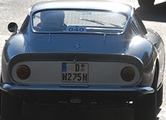

In [15]:
test_finetune(0)

In [18]:
from torch.utils.data import Dataset

class CustomClassifierDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        '''
        root_dir = 'Finetune/validation'
        jpg_path = 'JPEGImages/'
        '''
        with open('samples.pickle', 'rb') as fr:
            samples = pickle.load(fr)

        images = []
        positive_list = []
        negative_list = []

        name = root_dir.split('/')[-1]

        jpg_path = 'JPEGImages/'

        for idx in range(len(samples[name])):
            sample = samples[name][idx]
            images.append(cv2.imread(os.path.join(jpg_path, sample)))

            positive_annotation_path = os.path.join(root_dir, 'Annotations', sample.replace('.jpg', '_p.csv'))
            positive_annotations = np.loadtxt(positive_annotation_path, dtype=np.int, delimiter=' ')
    
            if len(positive_annotations.shape) == 1:
                if positive_annotations.shape[0] == 4:
                    positive_dict = dict()

                    positive_dict['rect'] = positive_annotations
                    positive_dict['image_id'] = idx
                    positive_list.append(positive_dict)
            else:
                for positive_annotation in positive_annotations:
                    positive_dict = dict()

                    positive_dict['rect'] = positive_annotation
                    positive_dict['image_id'] = idx
                    positive_list.append(positive_dict)

            negative_annotation_path = os.path.join(root_dir, 'Annotations', sample.replace('.jpg', '_p.csv'))
            negative_annotations = np.loadtxt(negative_annotation_path, dtype=np.int, delimiter=' ')

            if len(negative_annotations.shape) == 1:
                if negative_annotations.shape[0] == 4:
                    negative_dict = dict()
                    negative_dict['rect'] = negative_annotations
                    negative_dict['image_id'] = idx
                    negative_list.append(negative_dict)
            else:
                for negative_annotation in negative_annotations:
                    negative_dict = dict()

                    negative_dict['rect'] = negative_annotation
                    negative_dict['image_id'] = idx
                    negative_list.append(negative_dict)

        self.transform = transform
        self.images = images
        self.positive_list = positive_list
        self.negative_list = negative_list

    def __getitem__(self, index):
        if index < len(self.positive_list):
            target = 1
            positive_dict = self.positive_list[index]

            xmin, ymin, xmax, ymax = positive_dict['rect']
            image_id = positive_dict['image_id']

            image = self.images[image_id][ymin:ymax, xmin:xmax]
            cache_dict = positive_dict
        else:
            target = 0
            idx = index - len(self.positive_list)
            negative_dict = self.negative_list[idx]

            xmin, ymin, xmax, ymax = negative_dict['rect']
            image_id = negative_dict['image_id']

            image = self.images[image_id][ymin:ymax, xmin:xmax]
            cache_dict = negative_dict

        if self.transform:
            image = self.transform(image)

        return image, target, cache_dict

    def __len__(self):
        return len(self.positive_list) + len(self.negative_list)

    def get_transform(self):
        return self.transform

    def get_jpeg_images(self):
        return self.images

    def get_positive_num(self):
        return len(self.positive_list)

    def get_negative_num(self):
        return len(self.negative_list)

    def get_positives(self):
        return self.positive_list

    def get_negatives(self):
        return self.negative_list

    def set_negative_list(self, negative_list):
        self.negative_list = negative_list

In [15]:
def test_classifier(idx):
    root_dir = 'Finetune/validation'
    train_data_set = CustomClassifierDataset(root_dir)

    print('positive num: %d' % train_data_set.get_positive_num())
    print('negative num: %d' % train_data_set.get_negative_num())
    print('total num: %d' % train_data_set.__len__())

    image, target, cache_dict = train_data_set.__getitem__(idx)
    print('target: %d' % target)
    print('dict: ' + str(cache_dict))

    cv2_imshow(image)
    cv2.waitKey(0)

positive num: 707
negative num: 707
total num: 1414
target: 1
dict: {'rect': array([ 61, 119, 378, 224]), 'image_id': 0}


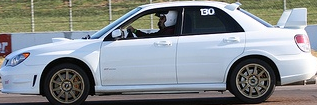

In [18]:
test_classifier(0)

In [19]:
class BBoxRegressionDataset():
    def __init__(self, root_dir, transform=None):
        '''
        root_dir = 'Finetune/train'
        
        bndboxes path = 'Finetune/train/bndboxes'
        positive path = 'Finetune/train/positive'
        두 파일과 관련 된 csv = 'Finetune/train/bbox'
        '''
        super(BBoxRegressionDataset, self).__init__()
        self.transform = transform

        name = root_dir.split('/')[-1]
        txt = np.loadtxt(os.path.join(root_dir, 'bbox', 'df.csv'), dtype=np.str)

        jpg_path = 'JPEGImages/'

        images = []
        box_list = []

        for i in range(len(txt)):
            sample = txt[i]

            jpeg_path = os.path.join(jpg_path, sample)
            bndbox_path = os.path.join(root_dir, 'bndboxes', sample.replace('jpg', 'csv'))
            positive_path = os.path.join(root_dir, 'positive', sample.replace('jpg', 'csv'))

            images.append(cv2.imread(jpeg_path))
            bndboxes = np.loadtxt(bndbox_path, dtype=np.int, delimiter=' ')
            positives = np.loadtxt(positive_path, dtype=np.int, delimiter=' ')

            if len(positives.shape) == 1:
                bndbox = self.get_bndbox(bndboxes, positives)
                box_list.append({'image_id': i, 'positive': positives, 'bndbox': bndbox})
            else:
                for positive in positives:
                    bndbox = self.get_bndbox(bndboxes, positive)
                    box_list.append({'image_id': i, 'positive': positive, 'bndbox': bndbox})

        self.images = images
        self.box_list = box_list

    def __getitem__(self, index: int):
        assert index < self.__len__(), 'The data set size is %d, and the current input subscript is %d' % (self.__len__(), index)

        box_dict = self.box_list[index]
        image_id = box_dict['image_id']
        positive = box_dict['positive']
        bndbox = box_dict['bndbox']

        jpeg_img = self.images[image_id]
        xmin, ymin, xmax, ymax = positive
        image = jpeg_img[ymin:ymax, xmin:xmax]

        if self.transform:
            image = self.transform(image)

        target = dict()
        p_w = xmax - xmin
        p_h = ymax - ymin
        p_x = xmin + p_w / 2
        p_y = ymin + p_h / 2

        xmin, ymin, xmax, ymax = bndbox
        g_w = xmax - xmin
        g_h = ymax - ymin
        g_x = xmin + g_w / 2
        g_y = ymin + g_h / 2

        t_x = (g_x - p_x) / p_w
        t_y = (g_y - p_y) / p_h
        t_w = np.log(g_w / p_w)
        t_h = np.log(g_h / p_h)

        return image, np.array((t_x, t_y, t_w, t_h))

    def __len__(self):
        return len(self.box_list)

    def get_bndbox(self, bndboxes, positive):
        if len(bndboxes.shape) == 1:
            return bndboxes
        else:
            scores = IoU(positive, bndboxes)
            return bndboxes[np.argmax(scores)]

In [20]:
import torchvision.transforms as transforms

def test_bbox():
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    root_dir = 'Finetune/train'
    data_set = BBoxRegressionDataset(root_dir, transform=transform)

    print(data_set.__len__())
    image, target = data_set.__getitem__(10)
    print(image.shape)
    print(target)
    print(target.dtype)

In [21]:
test_bbox()

3838
torch.Size([3, 227, 227])
[ 0.02419355  0.18571429 -0.06669137  0.10821358]
float64


In [21]:
from torch.utils.data import Sampler

class CustomBatchSampler(Sampler):
    def __init__(self, num_positive, num_negative, batch_positive, batch_negative):
        self.num_positive = num_positive
        self.num_negative = num_negative
        self.batch_positive = batch_positive
        self.batch_negative = batch_negative

        length = num_positive + num_negative
        self.idx_list = list(range(length))

        self.batch = batch_negative + batch_positive
        self.num_iter = length // self.batch

    def __iter__(self):
        sampler_list = list()
        for i in range(self.num_iter):
            tmp = np.concatenate(
                (random.sample(self.idx_list[:self.num_positive], self.batch_positive),
                 random.sample(self.idx_list[self.num_positive:], self.batch_negative))
            )
            random.shuffle(tmp)
            sampler_list.extend(tmp)
        return iter(sampler_list)

    def __len__(self):
        return self.num_iter * self.batch

    def get_num_batch(self):
        return self.num_iter

In [23]:
def test_batch():
    root_dir = 'Finetune/train'
    train_data_set = CustomFinetuneDataset(root_dir)
    
    # CustomBatchSampler(num_positive, num_negative, batch_positive, batch_negative)
    train_sampler = CustomBatchSampler(train_data_set.get_positive_num(), train_data_set.get_negative_num(), 32, 96)

    print('sampler len: %d' % train_sampler.__len__())
    print('sampler batch num: %d' % train_sampler.get_num_batch())

    first_idx_list = list(train_sampler.__iter__())[:128]
    print(first_idx_list)

    print('positive batch: %d' % np.sum(np.array(first_idx_list) < 66517))

In [24]:
test_batch()

sampler len: 51712
sampler batch num: 404
[396, 13122, 38320, 45345, 9157, 34982, 14754, 227, 380, 14229, 22109, 216, 644, 179, 48063, 6948, 3450, 42425, 49679, 6322, 35449, 51502, 44359, 10903, 23221, 17244, 37700, 555, 14871, 549, 10000, 22233, 23560, 33858, 37699, 5, 546, 38599, 3172, 7468, 98, 544, 35777, 45216, 13429, 38282, 11617, 18031, 10945, 42677, 6877, 4176, 49823, 363, 43830, 530, 332, 15568, 45134, 35974, 20, 37121, 14878, 49777, 565, 37767, 78, 426, 16703, 12053, 111, 19946, 15452, 47292, 543, 31492, 298, 15774, 34386, 51252, 21961, 10740, 22272, 763, 25125, 728, 9761, 665, 48527, 50937, 48637, 723, 38633, 21550, 36578, 12043, 123, 38253, 4984, 33873, 49152, 593, 50748, 24580, 20220, 45431, 71, 8729, 751, 27424, 11567, 46036, 20718, 48, 13555, 37398, 17381, 19102, 46356, 22845, 532, 27286, 10713, 40166, 23230, 48640, 28589, 14126]
positive batch: 128


In [22]:
class CustomHardNegativeMiningDataset():
    def __init__(self, negative_list, images, transform=None):
        self.negative_list = negative_list
        self.images = images
        self.transform = transform

    def __getitem__(self, index):
        target = 0

        negative_dict = self.negative_list[index]
        xmin, ymin, xmax, ymax = negative_dict['rect']
        image_id = negative_dict['image_id']

        image = self.images[image_id][ymin:ymax, xmin:xmax]

        if self.transform:
            image = self.transform(image)

        return image, target, negative_dict

    def __len__(self):
        return len(self.negative_list)

In [26]:
root_dir = 'Finetune/train'
data_set = CustomClassifierDataset(root_dir)

negative_list = data_set.get_negatives()
jpeg_images = data_set.get_jpeg_images()
transform = data_set.get_transform()

hard_negative_dataset = CustomHardNegativeMiningDataset(negative_list, jpeg_images, transform=transform)
image, target, negative_dict = hard_negative_dataset.__getitem__(100)

print(image.shape)
print(target)
print(negative_dict)

(373, 205, 3)
0
{'rect': array([  1,   1, 206, 374]), 'image_id': 25}


In [23]:
def load_data(data_root_dir):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_loaders = {}
    data_sizes = {}

    for name in ['train', 'validation']:
        data_dir = os.path.join(data_root_dir, name)
        data_set = CustomFinetuneDataset(data_dir, transform=transform)
        data_sampler = CustomBatchSampler(data_set.get_positive_num(), data_set.get_negative_num(), 32, 96)
        data_loader = DataLoader(data_set, batch_size=128, sampler=data_sampler, num_workers=2, drop_last=True)

        data_loaders[name] = data_loader
        data_sizes[name] = data_sampler.__len__()

    return data_loaders, data_sizes

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_loaders, data_sizes = load_data('./Finetune')

In [24]:
import copy

def train_model(data_loaders, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs ))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                lr_scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            running_corrects = running_corrects.type(torch.DoubleTensor)
            epoch_acc = running_corrects / data_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_weights)
    return model

In [27]:
import torchvision.models as models

model = models.alexnet(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [28]:
import torch.nn as nn

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
import torch.optim as optim

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_model = train_model(data_loaders, model, criterion, optimizer, lr_scheduler, device=device, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.0950 Acc: 0.9637
validation Loss: 0.1405 Acc: 0.9480

Epoch 2/25
----------
train Loss: 0.0316 Acc: 0.9897
validation Loss: 0.1526 Acc: 0.9531

Epoch 3/25
----------
train Loss: 0.0182 Acc: 0.9943
validation Loss: 0.1813 Acc: 0.9544

Epoch 4/25
----------
train Loss: 0.0111 Acc: 0.9969
validation Loss: 0.1873 Acc: 0.9549

Epoch 5/25
----------
train Loss: 0.0089 Acc: 0.9976
validation Loss: 0.1992 Acc: 0.9534

Epoch 6/25
----------
train Loss: 0.0071 Acc: 0.9981
validation Loss: 0.2074 Acc: 0.9549

Epoch 7/25
----------
train Loss: 0.0056 Acc: 0.9984
validation Loss: 0.2231 Acc: 0.9514

Epoch 8/25
----------
train Loss: 0.0046 Acc: 0.9988
validation Loss: 0.2127 Acc: 0.9565

Epoch 9/25
----------
train Loss: 0.0041 Acc: 0.9990
validation Loss: 0.2329 Acc: 0.9522

Epoch 10/25
----------
train Loss: 0.0037 Acc: 0.9991
validation Loss: 0.2229 Acc: 0.9542

Epoch 11/25
----------
train Loss: 0.0032 Acc: 0.9994
validation Loss: 0.2377 Acc: 0.9522

Epoch 12

In [27]:
model_path = './Finetune/models'

if not os.path.exists(model_path):
  os.mkdir(model_path)

torch.save(best_model.state_dict(), os.path.join(model_path, 'alexnet.pth'))

In [29]:
def load_data_svm(data_root_dir):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_loaders = {}
    data_sizes = {}
    remain_negative_list = list()
    for name in ['train', 'validation']:
        data_dir = os.path.join(data_root_dir, name)
        data_set = CustomClassifierDataset(data_dir, transform=transform)
        if name is 'train':
            positive_list = data_set.get_positives()
            negative_list = data_set.get_negatives()
            init_negative_idxs = random.sample(range(len(negative_list)), len(positive_list))
            init_negative_list = [negative_list[idx] for idx in range(len(negative_list)) if idx in init_negative_idxs]
            data_set.set_negative_list(init_negative_list)

            data_sampler = CustomBatchSampler(data_set.get_positive_num(), data_set.get_negative_num(), 1, 1)
            data_loader = DataLoader(data_set, batch_size=1, sampler=data_sampler, num_workers=2, drop_last=True)
            data_loaders['train'] = data_loader
            data_sizes['train'] = data_sampler.__len__()

            remain_negative_list = [negative_list[idx] for idx in range(len(negative_list))
                                    if idx not in init_negative_idxs]
            data_loaders['remain'] = remain_negative_list
            data_sizes['remain'] = remain_negative_list.__len__()

        if name is 'validation':
            data_sampler = CustomBatchSampler(data_set.get_positive_num(), data_set.get_negative_num(), 32, 96)
            data_loader = DataLoader(data_set, batch_size=128, sampler=data_sampler, num_workers=2, drop_last=True)

            data_loaders[name] = data_loader
            data_sizes[name] = data_sampler.__len__()

    return data_loaders, data_sizes

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_loaders, data_sizes = load_data_svm('Finetune')

In [30]:
def hinge_loss(outputs, labels):
    num_labels = len(labels)
    corrects = outputs[range(num_labels), labels].unsqueeze(0).T

    margin = 1.0
    margins = outputs - corrects + margin
    loss = torch.sum(torch.max(margins, 1)[0]) / len(labels)

    return loss

In [31]:
def add_hard_negatives(hard_negative_list, negative_list, add_negative_list):
    for item in hard_negative_list:
        if len(add_negative_list) == 0:
            negative_list.append(item)
            add_negative_list.append(list(item['rect']))
        if list(item['rect']) not in add_negative_list:
            negative_list.append(item)
            add_negative_list.append(list(item['rect']))

In [32]:
def get_hard_negatives(preds, cache_dicts):
    fp_mask = preds == 1
    tn_mask = preds == 0

    fp_rects = cache_dicts['rect'][fp_mask].numpy()
    fp_image_ids = cache_dicts['image_id'][fp_mask].numpy()

    tn_rects = cache_dicts['rect'][tn_mask].numpy()
    tn_image_ids = cache_dicts['image_id'][tn_mask].numpy()

    hard_negative_list = [{'rect': fp_rects[idx], 'image_id': fp_image_ids[idx]} for idx in range(len(fp_rects))]
    easy_negatie_list = [{'rect': tn_rects[idx], 'image_id': tn_image_ids[idx]} for idx in range(len(tn_rects))]

    return hard_negative_list, easy_negatie_list

In [34]:
def train_model_svm(data_loaders, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    batch_positive = 32
    batch_negative = 96
    batch_total = 128

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            data_set = data_loaders[phase].dataset
            print('{} - positive_num: {} - negative_num: {} - data size: {}'.format(
                phase, data_set.get_positive_num(), data_set.get_negative_num(), data_sizes[phase]))

            for inputs, labels, cache_dicts in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                lr_scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects / data_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        train_dataset = data_loaders['train'].dataset
        remain_negative_list = data_loaders['remain']
        jpeg_images = train_dataset.get_jpeg_images()
        transform = train_dataset.get_transform()

        with torch.set_grad_enabled(False):
            remain_dataset = CustomHardNegativeMiningDataset(remain_negative_list, jpeg_images, transform=transform)
            remain_data_loader = DataLoader(remain_dataset, batch_size=batch_total, num_workers=2, drop_last=True)

            negative_list = train_dataset.get_negatives()
            add_negative_list = data_loaders.get('add_negative', [])

            running_corrects = 0.0

            for inputs, labels, cache_dicts in remain_data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels.data)

                hard_negative_list, easy_neagtive_list = get_hard_negatives(preds.cpu().numpy(), cache_dicts)
                add_hard_negatives(hard_negative_list, negative_list, add_negative_list)

            if len(remain_negative_list) != 0:
                remain_acc = running_corrects / len(remain_negative_list)
            else:
                remain_acc = running_corrects / 1
            print('remain negative size: {}, acc: {:.4f}'.format(len(remain_negative_list), remain_acc))

            train_dataset.set_negative_list(negative_list)

            tmp_sampler = CustomBatchSampler(train_dataset.get_positive_num(), train_dataset.get_negative_num(),
                                             batch_positive, batch_negative)
            data_loaders['train'] = DataLoader(train_dataset, batch_size=batch_total, sampler=tmp_sampler,
                                               num_workers=2, drop_last=True)
            data_loaders['add_negative'] = add_negative_list
            data_sizes['train'] = len(tmp_sampler)

        torch.save(model.state_dict(), os.path.join(model_path, 'linear_svm_alexnet_%d.pth' % epoch))

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_weights)
    return model

In [ ]:
alexnet_path = os.path.join(model_path, 'alexnet.pth')
model = models.alexnet(pretrained=True)

num_classes = 2
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load(alexnet_path))
model.eval()

In [67]:
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(num_features, num_classes)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [70]:
model = model.to(device)

criterion = hinge_loss
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
lr_schduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

best_model = train_model_svm(data_loaders, model, criterion, optimizer, lr_schduler, num_epochs=10, device=device)

Epoch 1/10
----------
train - positive_num: 764 - negative_num: 764 - data size: 1408
train Loss: 1.2515 Acc: 0.6151
validation - positive_num: 707 - negative_num: 707 - data size: 1408
validation Loss: 1.2155 Acc: 0.6165
remiam negative size: 0, acc: 0.0000
Epoch 2/10
----------
train - positive_num: 764 - negative_num: 764 - data size: 1408
train Loss: 1.2408 Acc: 0.6136
validation - positive_num: 707 - negative_num: 707 - data size: 1408
validation Loss: 1.1833 Acc: 0.6193
remiam negative size: 0, acc: 0.0000
Epoch 3/10
----------
train - positive_num: 764 - negative_num: 764 - data size: 1408
train Loss: 1.2174 Acc: 0.6179
validation - positive_num: 707 - negative_num: 707 - data size: 1408
validation Loss: 1.1779 Acc: 0.5852
remiam negative size: 0, acc: 0.0000
Epoch 4/10
----------
train - positive_num: 764 - negative_num: 764 - data size: 1408
train Loss: 1.1909 Acc: 0.6250
validation - positive_num: 707 - negative_num: 707 - data size: 1408
validation Loss: 1.1554 Acc: 0.6442
r

In [71]:
torch.save(best_model.state_dict(), os.path.join(model_path, 'best_linear_svm_alexnet.pth'))

In [38]:
def load_data_bbox(data_root_dir):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_set = BBoxRegressionDataset(data_root_dir, transform=transform)
    data_loader = DataLoader(data_set, batch_size=128, shuffle=True, num_workers=2)

    return data_loader

In [ ]:
data_loader = load_data_bbox('Finetune/train')

In [40]:
def train_model_bbox(data_loader, feature_model, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    model.train()
    loss_list = list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        running_loss = 0.0

        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.float().to(device)

            features = feature_model.features(inputs)
            features = torch.flatten(features, 1)

            optimizer.zero_grad()

            outputs = model(features)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            lr_scheduler.step()

        epoch_loss = running_loss / data_loader.dataset.__len__()
        loss_list.append(epoch_loss)

        print('{} Loss: {:.4f}'.format(epoch + 1, epoch_loss))

        torch.save(model.state_dict(), os.path.join(model_path, 'bbox_regression_%d.pth' % epoch))

        print()

    return loss_list

In [41]:
def get_model(device=None):
    model = AlexNet(num_classes=2)
    model.load_state_dict(torch.load(os.path.join(model_path, 'best_linear_svm_alexnet.pth')))
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    if device:
        model = model.to(device)

    return model

In [83]:
from torchvision.models import AlexNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
feature_model = get_model(device)

in_features = 256 * 6 * 6
out_features = 4
model = nn.Linear(in_features, out_features)
model.to(device)

Linear(in_features=9216, out_features=4, bias=True)

In [84]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

loss_list = train_model_bbox(data_loader, feature_model, model, criterion, optimizer, lr_scheduler, device=device,
                        num_epochs=12)

Epoch 1/12
----------
1 Loss: 1.1361

Epoch 2/12
----------
2 Loss: 0.9976

Epoch 3/12
----------
3 Loss: 0.9974

Epoch 4/12
----------
4 Loss: 0.9962

Epoch 5/12
----------
5 Loss: 1.0157

Epoch 6/12
----------
6 Loss: 1.0024

Epoch 7/12
----------
7 Loss: 1.0123

Epoch 8/12
----------
8 Loss: 1.0072

Epoch 9/12
----------
9 Loss: 1.0030

Epoch 10/12
----------
10 Loss: 1.0007

Epoch 11/12
----------
11 Loss: 0.9977

Epoch 12/12
----------
12 Loss: 1.0077



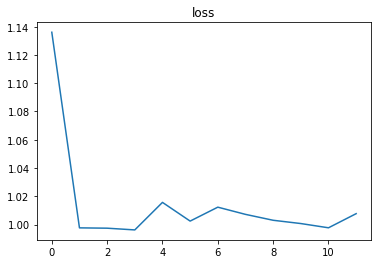

In [85]:
import matplotlib.pyplot as plt

x = list(range(len(loss_list)))
fg = plt.figure()

plt.plot(x, loss_list)
plt.title('loss')
plt.savefig('./loss.png')

In [42]:
def draw_box_with_text(img, rect_list, score_list):
    for i in range(len(rect_list)):
        xmin, ymin, xmax, ymax = rect_list[i]
        score = score_list[i]

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=(0, 0, 255), thickness=1)
        cv2.putText(img, "{:.3f}".format(score), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

In [43]:
def nms(rect_list, score_list):
    nms_rects = list()
    nms_scores = list()

    rect_array = np.array(rect_list)
    score_array = np.array(score_list)

    idxs = np.argsort(score_array)[::-1]
    rect_array = rect_array[idxs]
    score_array = score_array[idxs]

    thresh = 0.3
    while len(score_array) > 0:
        nms_rects.append(rect_array[0])
        nms_scores.append(score_array[0])
        rect_array = rect_array[1:]
        score_array = score_array[1:]

        length = len(score_array)
        if length <= 0:
            break

        iou_scores = iou(np.array(nms_rects[len(nms_rects) - 1]), rect_array)
        idxs = np.where(iou_scores < thresh)[0]
        rect_array = rect_array[idxs]
        score_array = score_array[idxs]

    return nms_rects, nms_scores

Suggested number of candidate areas: 1799
[294 195 334 253] tensor([0.0645, 0.6908], device='cuda:0') [0.3483406  0.65165937]
[266 138 314 162] tensor([-0.4347,  0.2384], device='cuda:0') [0.3378092 0.6621908]
[300 141 316 177] tensor([-0.6685,  0.0748], device='cuda:0') [0.3222917 0.6777083]
[161 116 198 162] tensor([-0.0385,  0.5728], device='cuda:0') [0.35174817 0.64825183]
[189 140 213 179] tensor([-0.7586,  0.3541], device='cuda:0') [0.24736392 0.7526361 ]
[254 137 312 178] tensor([-0.6302,  0.1074], device='cuda:0') [0.32353354 0.67646646]
[163 167 204 269] tensor([-0.0789,  0.8192], device='cuda:0') [0.28944188 0.7105581 ]
[181 140 213 179] tensor([-0.6370,  0.3030], device='cuda:0') [0.28090268 0.7190973 ]
[295 186 331 252] tensor([0.1434, 0.8060], device='cuda:0') [0.34015733 0.6598427 ]
detect time: 10 s
[array([189, 140, 213, 179], dtype=int32), array([163, 167, 204, 269], dtype=int32), array([300, 141, 316, 177], dtype=int32), array([254, 137, 312, 178], dtype=int32), array

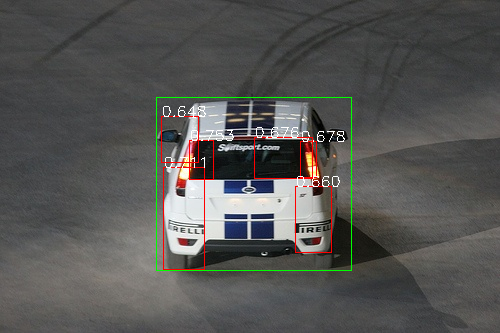

-1

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

model = models.alexnet(pretrained=True)

num_classes = 2
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load(os.path.join(model_path, 'best_linear_svm_alexnet.pth')))
model.eval()

for param in model.parameters():
    param.requires_grad = False

if device:
    model = model.to(device)

gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

test_img_path = './JPEGImages/000012.jpg'

img = cv2.imread(test_img_path)
dst = copy.deepcopy(img)

cond = df['file_name'] == test_img_path.split('/')[-1]
cols = ['xmin', 'ymin', 'xmax', 'ymax']

bndboxes = np.array(df.loc[cond, cols])
print(bndboxes)

for bndbox in bndboxes:
    xmin, ymin, xmax, ymax = bndbox
    cv2.rectangle(dst, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=1)

gs.setBaseImage(img)
gs.switchToSelectiveSearchFast()
rects = gs.process()
print('Suggested number of candidate areas: %d' % len(rects))

svm_thresh = 0.60
score_list = list()
positive_list = list()

print(rects.shape)

for rect in rects:
    xmin, ymin, xmax, ymax = rect
    rect_img = img[ymin:ymax, xmin:xmax]
    if rect_img[0] != 0 and rect_img[1] != 0:
        rect_transform = transform(rect_img).to(device)
        output = model(rect_transform.unsqueeze(0))[0]

        if torch.argmax(output).item() == 1:
            probs = torch.softmax(output, dim=0).cpu().numpy()

            if probs[1] >= svm_thresh:
                score_list.append(probs[1])
                positive_list.append(rect)
                print(rect, output, probs)

nms_rects, nms_scores = nms(positive_list, score_list)
print(nms_rects)
print(nms_scores)
draw_box_with_text(dst, nms_rects, nms_scores)

cv2_imshow(dst)
cv2.waitKey(0)

## Reference
- [R-CNN](https://github.com/object-detection-algorithm/R-CNN)

```
@misc{girshick2013rich,
    title={Rich feature hierarchies for accurate object detection and semantic segmentation},
    author={Ross Girshick and Jeff Donahue and Trevor Darrell and Jitendra Malik},
    year={2013},
    eprint={1311.2524},
    archivePrefix={arXiv},
    primaryClass={cs.CV}
}

@misc{pascal-voc-2007,
	author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
	title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2007 {(VOC2007)} {R}esults",
	howpublished = "http://www.pascal-network.org/challenges/VOC/voc2007/workshop/index.html"}

```